<div align=”center”>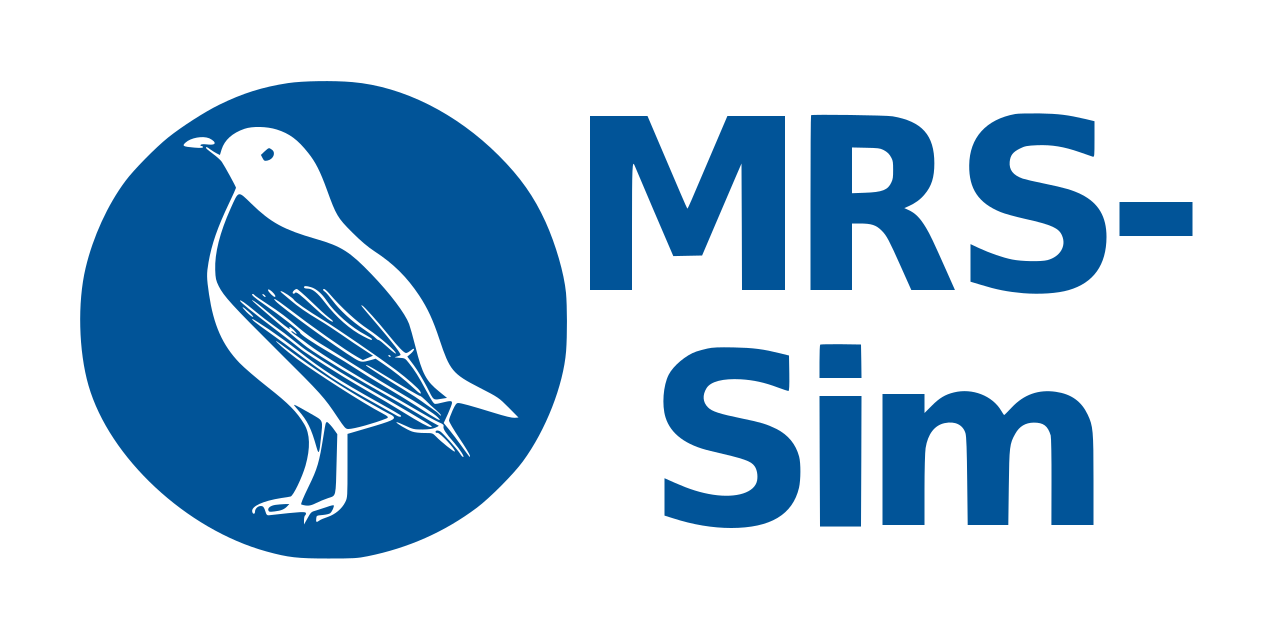</div>

- - -

# MRS-Sim Simulation Notebook

The simulation tutorial explains the different parts of the simulator and how to customize your simulations. The purpose of this notebook is to provide an alternative method to the command line. For details about the various parts, please refer back to the tutorial.

In [ ]:
import argparse
import json
import os
import sys

import numpy as np
import scipy.io as io
import torch
from types import SimpleNamespace

from src.aux import normalize
from src.main_fcns import _save, prepare, simulate


sys.path.append('../')

In [ ]:
config = {
    "totalEntries": 100,
    "PM_basis_set": "PRESS_30_GE_2000.mat",
    "NIfTIMRS": true,
    "metabolites": ["Asc", "Asp", "Ch", "Cr", "GABA", "Gln", "Glu", "GPC", "GSH", "Lac", "mI", "NAA", "NAAG", "PCh", "PCr", "PE", "sI", "Tau", "MM09", "MM12", "MM14", "MM17", "MM20", "Lip09", "Lip13", "Lip20"], 
    "wrt_metab": "Cr,PCr",
    "wrt_metab_ratio": [0.525,0.475],
    "snr_metab": "Cr,PCr",
    "B0": 3.0, 
    "TE": 30,
    "vendor": "GE",
    "cropRange": [0.2,4.2],
    "use_covmat": false, 
    "spectralwidth": 2000,
    "spectrum_length": 1024, 
    "basis_fcn_length": 2048,
    "image_resolution":    [ 0.5,  0.5,  0.5],
    "spectral_resolution": [10.0, 10.0, 10.0],
    "notes": "Here you can leave extra notes relevant to the simulation or experiments.",
    
    "apodize": false,
    "broadening": true,
    "lineshape": "voigt",
    "b0": true,
    "eddy": true,
    "fids": false,
    "fshift_g": true,
    "fshift_i": true,
    "phi0": true,
    "phi1": true,
    "magnitude": false,
    "noise": true,
    "mm_lip": false,
    "num_coils": 1,
    "coil_fshift": false,
    "coil_phi0": false,
    "coil_sens": false,
    "snr_combo": "both",
    "residual_water": true,
    "zero_fill": false,
    "resample": false,
    "drop_prob": 0.0,
    "snr": [10, 30], 
    "ppm_ref": 4.65,
    "covmat": {"matrix": null,
           "loc":    null},
    
    "parameters": {
        "_d":              [     3,    10],
        "_g":              [     5,    20],
        "_dmm":            [    10,   100],
        "_gmm":            [     5,    20],
        "f_shift":         [   -10,    10],
        "phi0":            [  -0.1,   0.1], 
        "phi1":            [ -0.05,  0.05], 
        "b0_dir":          [    -5,    15],
        "ppm_ref":                    4.65, 
        "snr_min":         [    10,    30], 
        "b0":              [   150,   200], 
        "coil_sens":       [     0,     2],
        "coil_fshift":     [   -20,    20],
        "coil_phi0":       [   -15,    15],
        "eddyCurrents_A":  [   1.0,  10.0],
        "eddyCurrents_tc": [  0.02,   0.3],
        "asc":             [   0.0,  0.16],
        "asp":             [   0.0,  0.16],
        "ch":              [   0.0,  0.20],
        "gaba":            [   0.0,  0.90],
        "glc":             [   0.0,  0.23],
        "gln":             [   0.0,  0.42],
        "glu":             [   0.0,  3.00],
        "gly":             [   0.0,  0.50],
        "gpc":             [   0.0,  0.44],
        "gsh":             [   0.0,  0.18],
        "lac":             [   0.0,  0.04],
        "mi":              [   0.0,  0.90],
        "naa":             [   0.0,  3.50],
        "naag":            [   0.0,  0.65],
        "pch":             [   0.0,  0.22],  
        "pcr":             [   0.3,   1.0],
        "pe":              [   0.0,  0.40],
        "si":              [   0.0,  0.80],
        "tau":             [   0.0,  0.22],
        "mm09":            [   0.0,  15.0],
        "mm12":            [   0.0,  15.0],
        "mm14":            [   0.0,  15.0],
        "mm17":            [   0.0,  15.0],
        "mm20":            [   0.0,  15.0],
        "lip09":           [   0.0,  15.0],
        "lip13":           [   0.0,  15.0],
        "lip20":           [   0.0,  15.0]
    },
    
    "baseline_cfg": {
        "start":           [            0],
        "end":             [            0],
        "upper":           [            1],
        "lower":           [           -1],
        "std":             [  0.05,  0.20],
        "window":          [  0.15,   0.3],
        "pt_density":          128,
        "cropRange":       [  -1.6,   8.5],
        "scale":           [     1,   1.0],
        "drop_prob":           0.0
    },

    "resWater_cfg": {
        "upper":           [     0,     1],
        "lower":           [     0,     1],
        "std":             [   0.2,  0.40],
        "window":          [         0.01],
        "pt_density":         1204,
        "cropRange_water": [   4.4,   4.9],
        "cropRange":       [     0,     5],
        "prime":              0.15,
        "scale":           [  0.05,  0.20],
        "drop_prob":           0.0
    }    
}

In [ ]:
def sample(inputs):
    # Do NOT change the following line!
    config, resWater_cfg, baseline_cfg, pm, l, ind, p, totalEntries = inputs

    # Sample parameters from a uniform distribution - deep learning application
    params = torch.ones((totalEntries, ind['overall'][-1]+1)).uniform_(0,1)
    
    # normalization converts the range from [0,1) to [0,1].
    params = normalize(params, dims=-1) 
    
    # Quantify parameters
    params = pm.quantify_params(params)
    
    '''
    This next section of code will need to be customized for your own implementations.
    '''

    # All metabolite values are ratios wrt some other metabolite or group of metabolites.
    # Therefore, the reference metab or pair/group will always sum to 1.0
    if len(config.wrt_metab.split(','))==1: wrt_metab_ratio = [1]
    for m, v in zip(config.wrt_metab.split(','),wrt_metab_ratio):
        assert(m in config.metabolites)
        params[:,ind[m.lower()]].fill_(v)
    
    '''
    The next section of code is used to drop some parameters from each spectrum for deep learning applications.
    Should you want to use different distributions for some of the parameters, the following can be used as a 
    guide. Defining different distributions can be done before OR after quantifying the parameters.
    '''
    print('>>> Line Broadening')
    keys, g = ind.keys(), 0
    for k in keys: g += 1 if 'mm' in k else 0
    for k in keys: g += 1 if 'lip' in k else 0

    # Drop Lorentzian (D) from some metabolites
    if config.lineshape in ['voigt','lorentzian']:
        for n in ind['d']:
            sign = torch.tensor([True if torch.rand([1]) > p else False for _ in range(params.shape[0])])
            params[sign,n].fill_(0.)
    else:
        for n in ind['d']: params[:,n].fill_(0.0)
        
    # One Gaussian value is used for metabolites and the other is used for MM/Lip - but only 2 values!
    # Should an additional group be separated, this and the pm.initialize() code will need to be updated.
    if config.lineshape in ['voigt','gaussian']:
        for n in ind['g']:
            if n==0 || n==int(l-g-1):
                sign = torch.tensor([True if torch.rand([1]) > p else False for _ in range(params.shape[0])])
                params[sign,n].fill_(0.)

            if n>0 and n<l-g-1:
                params[:,n] = params[:,ind['g'][0]].clone()
            if n>l-g-1:
                params[:,n] = params[:,ind['g'][int(l-g-1)]].clone()
    else:
        for n in ind['g']: 
            params[:,n].fill_(0.0)
            
    
    print('>>> Transients')
    factors = torch.distributions.normal.Normal(1,0.25).sample(params[:,ind['coil_snr']].shape)
    params[:,ind['coil_snr']] = factors
    # Values are sampled from a Gaussian mu=1, min/max=0/2
    # The linear SNR is calculated and scaled based on the number of transients
    # Then the linear SNR is scaled about 1.0 so mu = lin_snr
    if config.coil_sens:
        print('>>> Coil Sensitivities')
        params[:,ind['coil_sens']] = torch.distributions.normal.Normal(1,0.5).sample(params[:,ind['coil_sens']].shape).clamp(min=0.0,max=2.0)
        sign = torch.tensor([True if torch.rand([1]) > p else False for _ in range(params.shape[0])])
        params[sign,ind['coil_sens']].fill_(1.0)

    if config.coil_fshift:
        print('>>> Coil Frequency Drift')
        factors = torch.distributions.normal.Normal(1,0.25).sample(params[:,ind['coil_fshift']].shape)
        params[:,ind['coil_fshift']] = factors * params[:,ind['coil_fshift']][0]
        sign = torch.tensor([True if torch.rand([1]) > p else False for _ in range(params.shape[0])])
        params[sign,ind['coil_fshift']].fill_(0.0)

    if config.coil_phi0:
        print('>>> Coil Phase Drift')
        factors = torch.distributions.normal.Normal(1,0.25).sample(params[:,ind['coil_phi0']].shape)
        params[:,ind['coil_phi0']] = factors * params[:,ind['coil_phi0']][0]
        sign = torch.tensor([True if torch.rand([1]) > p else False for _ in range(params.shape[0])])
        params[sign,ind['coil_phi0']].fill_(0.0)

    '''
    If certain parts of the model are turned off, then their values should be zeroed out.
    '''
    if not config.b0:
        params[:,ind['b0']].fill_(0.0)
        for n in ind['b0_dir']: params[:,n].fill_(0.0)
    # D is dealt with above
    if not config.eddy: 
        for n in ind['ecc']: params[:,n].fill_(0.0)
    if not config.fshift_g: params[:,ind['f_shift']].fill_(0.0)
    if not config.fshift_i:
        for n in ind['f_shifts']: params[:,n].fill_(0.0)
    # G is dealt with above
    if not config.noise: params[:,ind['snr']].fill_(0.0)
    if not config.phi0: params[:,ind['phi0']].fill_(0.0)
    if not config.phi1: params[:,ind['phi1']].fill_(0.0)
    if config.num_coils<=1:
        params[:,ind['coil_snr']].fill_(0.0)
        params[:,ind['coil_sens']].fill_(0.0)
        params[:,ind['coil_fshift']].fill_(0.0)
        params[:,ind['coil_phi0']].fill_(0.0)
    
    
    return config, resWater_cfg, baseline_cfg, pm, l, ind, p, totalEntries, params

In [ ]:
# Change the default values to your specified inputs. If you have no changes for a particular argument, 
# then leave it as it is.
parser = argparse.ArgumentParser()
parser.add_argument('--savedir', type=str, default='./dataset/30ms_publication')
parser.add_argument('--batchSize', type=int, default=10000)
parser.add_argument('--stepSize', type=int, default=10000)
parser.add_argument('--parameters', type=str, default=None, help='Path to .mat file with pre-sampled parameters')
parser.add_argument('--config_file', type=str, default='./src/configurations/debug_new_init.json')

# Parse the arguments
args = parser.parse_args()

# Make sure that the save directory exists
os.makedirs(args.savedir, exist_ok=True)

# Save the config dictionary as a json file for future reference
json_config = json.dumps(config, indent=4)
with open(os.path.join(args.savedir,'config.json'), 'w') as file:
    file.write(json_config)

In [ ]:
# Initialize the model and sample the parameters needed for the simulations
if isinstance(args.parameters, str):
    from src.aux import load_parameters
    sampled = load_parameters(args.parameters, prepare(args.config_file))
else:
    sampled = sample(prepare(args.config_file))

# Simulate and export the spectra
path = simulate(sampled,args=args)

# Save the parameters as a .mat file
io.savemat(path+'_sampled_parameters.mat', mdict={'params': sampled[-1]})